**Neuro-AI: Harnessing AI to understand computation in mind and brain**  
**Day 3: Neural encoding, decoding & reconstruction with deep learning**  

# Reconstructing handwritten digits from fMRI recordings

In tutorial, you will implement a neural decoder for reconstructing perceived stimuli from brain responses.

The dataset contains fMRI data acquired from the early visual cortex of one subject as the subject was presented with 100 grayscale images of handwritten sixes and nines (50 sixes and 50 nines). The fMRI data has been realigned and slice time corrected. Furthermore, stimulus specific response amplitudes have been estimated with a general linear model.

Let's first familiarize ourselves with the dataset. It contains a number of variables:

* **X** (stimuli) -> This is a 100 x 784 matrix. Each ith row contains the pixel values of a stimulus that was presented in the ith trial of the experiment. Note that the stimuli are 28 pixel x 28 pixel images, which were reshaped to 1 x 784 vectors.

* **Y** (brain data) -> This is a 100 x 3092 matrix. The ith row contains the voxel values of the responses that were measured in the ith trial of the experiment.

* **X_prior** (auxiliary images) -> This is a 2000 x 784 matrix. Each row contains the pixel values of a different stimulus, which was _not_ used in the experiment. Note that the stimuli are 28 pixel x 28 pixel images, which were reshaped to 1 x 784 vectors. You will be needing **X_prior** in task 3.

Note: In the remainder of this document, we will use **x** for referring to a 784 x 1 stimulus vector and **y** for referring to a 3092 x 1 response vector.

## Task 1

* Load the dataset.
* Visualize some of the stimuli.
* Normalize X and Y and X_prior to have zero mean and unit variance. Tip: Recall that normalization means subtracting the mean of each pixel/voxel from itself and dividing it by its standard deviation. Also save these means and standard deviations as you will need them to denormalize the predictions again, for visualization purposes.
* Split X and Y in two parts called X_training and X_test, and Y_training and Y_test. The training set should contain 80 stimulus-response pairs (40 pairs for sixes and 40 pairs for nines -- use the labels to evenly split these two categories). The test set should contain 20 stimulus-response pairs (10 pairs for sixes and 10 pairs for nines). Note that label 1 and 2 correspond to sixes and nines, respectively.

In [ ]:
!wget -nc https://github.com/tdado/NeuroAI24/raw/main/Basic/69dataset.mat

import random
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
from scipy.stats import t

# Load the dataset
data = scipy.io.loadmat("69dataset.mat")
print(data.keys())

X = data["X"]              # Shape: (100, 784)
Y = data["Y"]              # Shape: (100, 3092)
X_prior = data["prior"]    # Shape: (2000, 784)
labels = data["labels"]    # Shape: (100, 1)

File ‘69dataset.mat’ already there; not retrieving.

dict_keys(['__header__', '__version__', '__globals__', 'structural', 'funloc', 'masks', 'prior', 'labels', 'Y', 'X', 'description'])


In [ ]:
### Your code here

##### answer

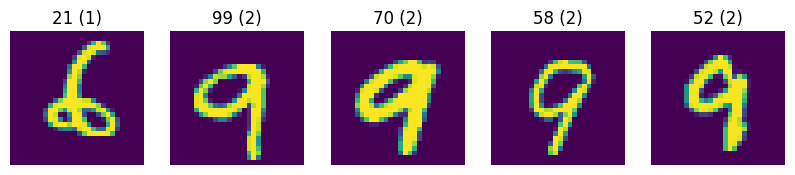

In [ ]:
# Visualize some of the stimuli
# You see it's both 6s and 9s
random_indices = random.sample(range(X.shape[0]), 5)
plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[idx].reshape((28, 28)).T)
    plt.axis('off')
    plt.title(f"{idx} ({labels[idx, 0]})")
plt.show()

In [ ]:
# Normalize X, Y and X_prior to have zero mean and unit variance
X_mu = np.mean(X, axis=0)
X_sd = np.std(X, axis=0)
X_sd[X_sd == 0] = 1
X_norm = (X - X_mu) / X_sd

Y_mu = np.mean(Y, axis=0)
Y_sd = np.std(Y, axis=0)
Y_sd[Y_sd == 0] = 1
Y_norm = (Y - Y_mu) / Y_sd

X_prior_mu = np.mean(X_prior, axis=0)
X_prior_sd = np.std(X_prior, axis=0)
X_prior_sd[X_prior_sd == 0] = 1
X_prior_norm = (X_prior - X_prior_mu) / X_prior_sd

# sort sixes and nines, randomize
sixes_idx = np.where(labels[:, 0] == 1)[0]
nines_idx = np.where(labels[:, 0] == 2)[0]
np.random.shuffle(sixes_idx)
np.random.shuffle(nines_idx)

# split training and test, randomize
idx_tr = np.hstack((sixes_idx[:40], nines_idx[:40]))
idx_te = np.hstack((sixes_idx[40:], nines_idx[40:]))
np.random.shuffle(idx_tr)
np.random.shuffle(idx_te)

x_tr = X_norm[idx_tr]
y_tr = Y_norm[idx_tr]
x_te = X_norm[idx_te]
y_te = Y_norm[idx_te]
x_tr.shape, y_tr.shape, x_te.shape, y_te.shape

((80, 784), (80, 3092), (20, 784), (20, 3092))

## Task 2

Our goal is to solve the problem of reconstructing **x** from **y**. One possible approach to solve this problem is to use a *discriminative* model. Discriminative models predict **x** as a function of **y**. That is:

$y = f(x)$

We will assume that f is a linear function. That is:

$x = B^\top y$

$f$ can be seen as a very simple linear neural network comprising one layer of weights (i.e., $B$). The aim of ridge regression is to minimize the objective function:

$L(B) = \|X - YB\|^2 + \lambda \|B\|^2$

$B$ can be estimated in closed form:

$B = (Y_{tr}^\top Y_{tr} + \lambda I)^{-1} Y_{tr}^\top X_{tr}$

where $\lambda$ is the regularization coefficient, $I$ is the $q \times q$ identity matrix, and $q$ is the number of voxels. Note that we can safely ignore the intercept since we normalized our data to have zero mean and unit variance.

* Provide a derivation of the above closed-form solution for $B$ by setting the derivative of $L(B)$ to zero and find the optimal $B$.
* Estimate $B$ on the training set. Tip: Normally, you should use cross validation to estimate lambda. For simplicity, you can assume that $\lambda = 10^{-6}$.
* Reconstruct $x$ from $y$ in the test set.
* Visualize the reconstructions.

ToThink 1: This model predicted the pixel values of an image by taking a linear combination of the stimulus-evoked brain responses. Does this imply that the relationship between responses and pixels of handwritten digits is inherently linear?

In [ ]:
### Your code here

##### answer

$L(B) = \|X - YB\|^2 + \lambda \|B\|^2$

Expand:  
$L(B) = (X - YB)^\top (X - YB) + \lambda B^\top B$

Differentiate:  
$\frac{\partial L}{\partial B} = -2Y^\top X + 2Y^\top YB + 2\lambda B = 0$

Simplify and solve for $B$:  
$Y^\top YB + \lambda B = Y^\top X$  
$(Y^\top Y + \lambda I)B = Y^\top X$  
$B = (Y^\top Y + \lambda I)^{-1} Y^\top X$  



(784, 20)


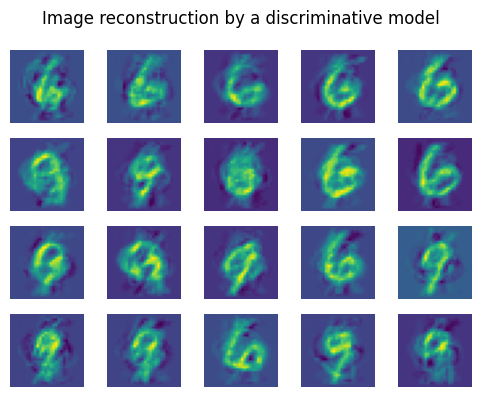

In [ ]:
# Discriminative model: P(x|y)

# ridge regression
lam = 10 ** -6
I_y = np.identity(y_tr.shape[1])
B_y = (np.linalg.inv(y_tr.T @ y_tr + lam * I_y)) @ (y_tr.T @ x_tr)

# x|y
x_hat = (y_te @ B_y).T
print(x_hat.shape)

x_denormalised = x_hat.T * X_sd + X_mu
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(x_denormalised[i].reshape(28, 28).T)
    plt.axis("off")
plt.suptitle('Image reconstruction by a discriminative model')
plt.tight_layout()
plt.show()

# ToThink 1: No, the linear relationship is a simplification and may not capture
# the full complexity of the underlying relationship. However, these results show
# that linear models can be powerful tools even in scenarios involving complex neural data.

## Task 3.1

Another possible approach to solve the problem of reconstructing **x** from **y** is to use a *generative* model and invert it with Bayes' rule. We reformulate the problem as finding the most probable **x** that could have caused **y**. That is:

argmax_**x** P(**x** | **y**)

where P(**x** | **y**) is called the posterior (probability of the stimulus being **x** if the observation is **y**). In other words, we have to define the posterior, estimate its parameters and find the argument that maximizes it, which will be the reconstruction of **x** from **y**. While, this may seem daunting, it actually has a simple solution. The posterior assigns a probability to an event by combining our observations and beliefs about it, and can be decomposed with Bayes' rule as the product of how likely our observations are given the event (probability of observing **y** if the stimulus is **x**) and how likely the event is independent of our observations (probability of the stimulus being **x**). That is:

P(**x** | **y**) ~ P(**y** | **x**) * P(**x**)

where P(**y** | **x**) is called the likelihood and P(x) is called the prior.

We will assume that the likelihood and the prior are multivariate Gaussian distributions. A Gaussian is characterized by two parameters: a mean vector and a covariance matrix. In the case of the likelihood, the mean of the Gaussian is given by:

**mu**\_likelihood = **B'** **x**

As before, we can estimate **B** in close form with ridge regression:

**B** = inv(**X**\_training' **X**\_training + lambda **I**) **X**\_training' **Y**\_training

where lambda is the regularization coefficient, I is the *p* x *p* identity matrix, and *p* is the number of pixels. The covariance matrix of the likelihood is given by:

**Sigma**_likelihood = diag(E[||**y** - **B'** **x**|| ^ 2]).

In the case of the prior, the mean of the Gaussian is given by:

**mu**\_prior = **0** (which is a vector of zeros)

The covariance matrix of the prior is given by:

**Sigma**\_prior = **X**\_prior' * **X**\_prior / (n - 1)

where n is the length of **X**\_prior.

* Estimate **B** on the training set. Tip: Normally, you should use cross-validation to estimate lambda and Sigma_likelihood. For simplicity, you can assume that lambda = 10 ^ -6 and Sigma_likelihood = 10 ^ -3 **I**.
* Estimate **Sigma**\_prior. Tip: Add 10 ^ -6 to the diagonal of Sigma_prior for regularization.
* Visualize **Sigma**\_prior.

ToThink 2: What does the visualized **Sigma**\_prior shows? Can you also visualize the covariance of one pixel (take one in the middle) -- what does this tell you?

In [ ]:
### Your code here

##### answer

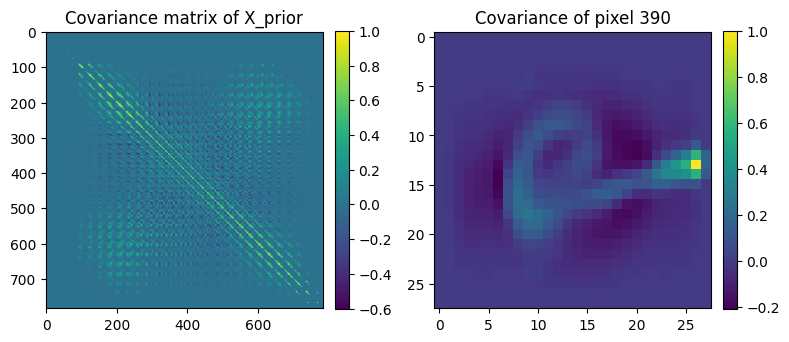

In [ ]:
# Generative model: P(x, y) to derive P(x|y)

# ridge regression (y|x)
lam = 10 ** -6
I_x = np.identity(x_tr.shape[1])
B_x = (np.linalg.inv(x_tr.T @ x_tr + lam * I_x)) @ (x_tr.T @ y_tr)

# likelihood
mu_likelihood = (x_tr @ B_x).T
sigma_likelihood = lam * I_y

# sigma prior
mu_prior = 0
sigma_prior = X_prior_norm.T @ X_prior_norm / (len(X_prior_norm) - 1)

# regularization (add 10**-6 to diagonal)
for i in range(sigma_prior.shape[0]):
    sigma_prior[i, i] += 10**-6

# visualize sigma prior
plt.figure(figsize=(8, 5))
ax1 = plt.subplot(1, 2, 1)
im1 = plt.imshow(sigma_prior)
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
plt.title('Covariance matrix of X_prior')

# visualize covariance for one pixel to get an idea
pixel = 390
ax2 = plt.subplot(1, 2, 2)
im2 = ax2.imshow(sigma_prior[pixel].reshape(28, 28))
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
plt.title(f"Covariance of pixel {pixel}")
plt.tight_layout()
plt.show()


# ToThink 2:
# matrix: covariance is highest on the diagonal (I.e., covariance pixel with itself)
# covariance of one specific pixel with all other pixels. The off-diagonal elements
# represent the covariance between different pixels. These values can show patterns
# indicating how pairs of pixels vary together. Regions with high covariance indicate
# pixels that tend to change together, revealing underlying structures in the images.
# This visualization shows how this particular pixel covaries with all other pixels
# in the image. Strikingly, by looking at just one pixel (naturally somewhere in the
# middle, and not at the edge such as pixel 0) already shows a covariance pattern that
# resembles an entire picture of a digit. his indicates that changes in this pixel
# are strongly related to changes in many other pixels that form the digit's shape.

## Task 3.2

Having defined the likelihood and the prior as Gaussians, we can derive the posterior by multiplying them. It turns out that the product of two Gaussians is another Gaussian, whose mean vector is given by:

**mu**\_posterior = inv(inv(**Sigma**\_prior) + **B** inv(**Sigma**\_likelihood) **B**') **B** * inv(**Sigma**\_likelihood) **y**

We are almost done. Recall that the reconstruction of **x** from **y** is the argument that maximizes the posterior, which we derived to be a Gaussian. We will be completely done once we answer the following question: What is the argument that maximizes a Gaussian?

.  
.  
.  
.  
.  
.

The answer is its mean vector, which is the solution of our initial problem. That is:

argmax_**x** P(**x** | **y**) =  
**mu**\_posterior =  
inv(inv(**Sigma**\_prior) + **B** inv(**Sigma**\_likelihood) **B**') **B** * inv(**Sigma**\_likelihood) **y**

ToThink 3: Why does the mean vector of the posterior distribution represent the most probable $x$ given $y$?

Now, we can plug any **y** in the above equation and reconstruct the most probable **x** that could have caused it.

- Reconstruct **x** from **y** in the test set.
- Visualize the reconstructions.

ToThink 4: Compare the reconstructions with the earlier reconstructions. Which one is better? Why? Can you think of ways to improve the results?

In [ ]:
### Your code here

##### answer

(784, 20)


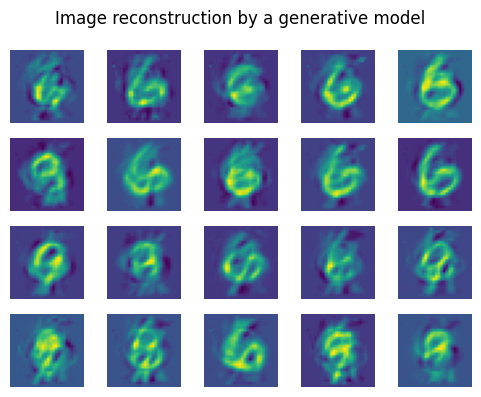

In [ ]:
# ToThink 3: in a Gaussian distribution, the mean is the point of highest
# probability density.

# Generative model: P(x, y) to derive P(x|y)

# mu_posterior = inv(inv(Sigma_prior) + B inv(Sigma_likelihood) B') B * inv(Sigma_likelihood) y
sigma_prior_inv = np.linalg.inv(sigma_prior)
B_sigma_likelihood_inv = B_x @ np.linalg.inv(lam * np.identity(y_te.shape[1]))
term1 = np.linalg.inv(sigma_prior_inv + B_sigma_likelihood_inv @ B_x.T)

# x|y
mu_posterior = term1 @ B_sigma_likelihood_inv @ y_te.T
print(mu_posterior.shape)

mu_denormalised = mu_posterior.T * X_sd + X_mu
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(mu_denormalised[i].reshape(28, 28).T)
    plt.axis("off")
plt.suptitle('Image reconstruction by a generative model')
plt.tight_layout()
plt.show()

# ToThink 4: although the generative model has informative prioer (X_prior;
# the probability of the stimuli independent of our observations) in addition to
# voxel responses to the test stimuli, the discriminative reconstructions appear
# perceptually more similar to the stimuli.

# - better prior that adequately captures true distribution of X
# - model complexity, use nonlinear models

## Task 5

Quantify the reconstruction performance in terms of pixel similarity: the Pearson correlation coefficient between predicted and actual pixel values in the stimuli and reconstructions, respectively.

ToThink 5: what is the downside of this metric? Can you propose a more human-centric metric to assess reconstruction performance?

In [ ]:
def pearson_correlation_coefficient(x: np.ndarray, y: np.ndarray, axis: int) -> np.ndarray:
    r = (np.nan_to_num(stats.zscore(x)) * np.nan_to_num(stats.zscore(y))).mean(axis)
    p = 2 * t.sf(np.abs(r / np.sqrt((1 - r ** 2) / (x.shape[0] - 2))), x.shape[0] - 2)
    return r, p

In [ ]:
### Your code here

##### answer

In [ ]:
i = 0
print(pearson_correlation_coefficient(x_te[i], x_denormalised[i], 0))
print(pearson_correlation_coefficient(x_te[i], mu_denormalised[i], 0))

# ToThink 5: Pixel correlation can be overly sensitive to exact alignment and intensity
# variations, which might not necessarily capture perceptual similarities recognized
# by human observers. A more human-centric metric is perceptual similarity: extract
# the features (for instance, of VGG16) from the stimulus and of the reconstructions
# and compare those rather the raw pixel values. These high-level features can offer
# an assessment that's closer to human judgement.

(0.28590084749178507, 3.2559180244716856e-16)
(0.2515967869094141, 8.755523483211782e-13)


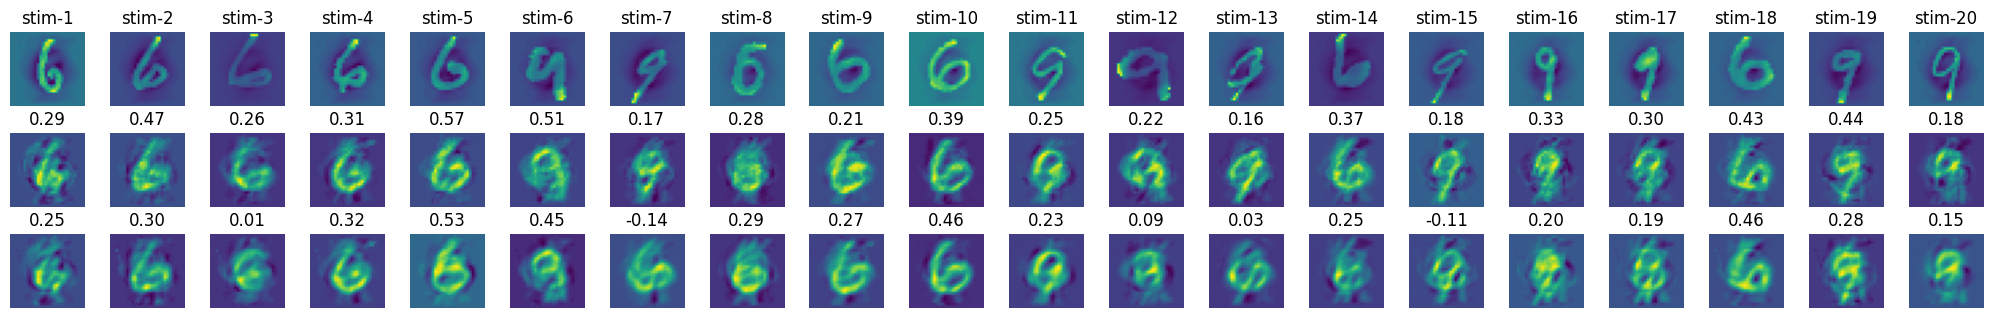

In [ ]:
fig, axs = plt.subplots(3, 20, figsize=(20, 3))
for i in range(20):
    axs[0, i].imshow(x_te[i].reshape(28, 28).T)
    axs[0, i].axis('off')
    axs[0, i].set_title("stim-%i" % (i+1))
    axs[1, i].imshow(x_denormalised[i].reshape(28, 28).T)
    axs[1, i].axis('off')
    axs[1, i].set_title("%.2f" % (pearson_correlation_coefficient(x_te[i], x_denormalised[i], 0)[0]))
    axs[2, i].imshow(mu_denormalised[i].reshape(28, 28).T)
    axs[2, i].axis('off')
    axs[2, i].set_title("%.2f" % (pearson_correlation_coefficient(x_te[i], mu_denormalised[i], 0)[0]))
plt.tight_layout(pad=0.1, h_pad=0.5, w_pad=0.1)
plt.show()